In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline
 
from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.loss import RMSELoss
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Loading specific settings (some defined by the "run-notebooks.sh" script)

In [3]:
%run settings.py

dataset = cfsr
step = 5
lr = 0.001
model_name = stconvs2s-r
version = 4
cuda = 1
dropout_rate = 0.0
only_training = False
epochs = 50
batch_size = 15
validation_split = 0.2
test_split = 0.2
dataset_file = ../data/dataset-ucar-1979-2015-seq5-ystep5.nc
model_param = {'num_layers': 3, 'kernel_size': 5, 'hidden_dim': 32}


In [4]:
util = Util(model_name, version=version, prefix=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]=cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Seed (reproducibility)

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Loading the dataset

In [7]:
ds = xr.open_mfdataset(dataset_file)
if small_dataset: #useful for quick experimentation
    ds = ds[dict(sample=slice(0,500))]

In [8]:
train_dataset = NetCDFDataset(ds, test_split=test_split, 
                              validation_split=validation_split)
val_dataset   = NetCDFDataset(ds, test_split=test_split, 
                              validation_split=validation_split, is_validation=True)
test_dataset  = NetCDFDataset(ds, test_split=test_split, 
                              validation_split=validation_split, is_test=True)

In [9]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([32427, 1, 5, 32, 32])
[y_train] Shape: torch.Size([32427, 1, 5, 32, 32])
[X_val] Shape: torch.Size([10810, 1, 5, 32, 32])
[y_val] Shape: torch.Size([10810, 1, 5, 32, 32])
[X_test] Shape: torch.Size([10810, 1, 5, 32, 32])
[y_test] Shape: torch.Size([10810, 1, 5, 32, 32])


In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [11]:
model_bulder = models[model_name]
print(model_bulder)

model = model_bulder(train_dataset.X.shape, model_param['num_layers'], model_param['hidden_dim'], 
                     model_param['kernel_size'], device, dropout_rate)
model.to(device)
criterion = RMSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9, eps=1e-6)

<class 'model.stconvs2s.STConvS2S_R'>


Training the model

In [12]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                  device, util, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename, is_chirps)

Train on 32427 samples, validate on 10810 samples
Epoch: 1/50 - loss: 2.1299 - val_loss: 1.7008
=> Saving a new best
Epoch: 2/50 - loss: 1.6825 - val_loss: 1.6390
=> Saving a new best
Epoch: 3/50 - loss: 1.6205 - val_loss: 1.6270
=> Saving a new best
Epoch: 4/50 - loss: 1.5782 - val_loss: 1.4645
=> Saving a new best
Epoch: 5/50 - loss: 1.5453 - val_loss: 1.4819
Epoch: 6/50 - loss: 1.5157 - val_loss: 1.5301
Epoch: 7/50 - loss: 1.4879 - val_loss: 1.4245
=> Saving a new best
Epoch: 8/50 - loss: 1.4705 - val_loss: 1.4007
=> Saving a new best
Epoch: 9/50 - loss: 1.4552 - val_loss: 1.3897
=> Saving a new best
Epoch: 10/50 - loss: 1.4413 - val_loss: 1.4587
Epoch: 11/50 - loss: 1.4297 - val_loss: 1.4616
Epoch: 12/50 - loss: 1.4196 - val_loss: 1.4158
Epoch: 13/50 - loss: 1.4125 - val_loss: 1.3592
=> Saving a new best
Epoch: 14/50 - loss: 1.4040 - val_loss: 1.3505
=> Saving a new best
Epoch: 15/50 - loss: 1.3975 - val_loss: 1.3639
Epoch: 16/50 - loss: 1.3914 - val_loss: 1.3699
Epoch: 17/50 - los

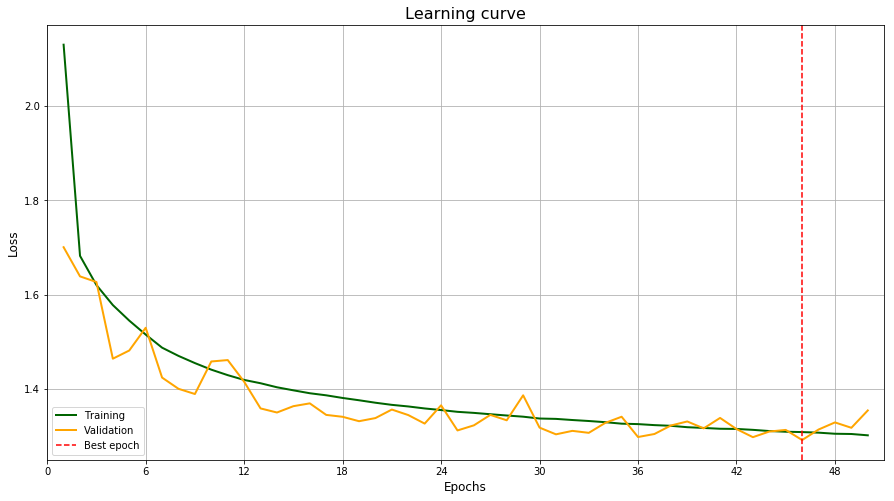

In [13]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Loss', 'Learning curve', inline=True)

Loading and Evaluating the model

=> Loaded checkpoint cfsr_4_20200911-074023.pth.tar (best epoch: 46, validation rmse: 1.2922)
>>>>>>>>> Metric per observation (lat x lon) at each time step (t)
RMSE
0.9381201292043255,1.1300699994402024,1.2741832977855752,1.4021886416843958,1.5715464150194651
MAE
0.633711779001847,0.7743780870874116,0.8846617690733171,0.973895126176112,1.0927074850845602
>>>>>>>>
Test RMSE: 1.2823
Test MAE: 0.8719


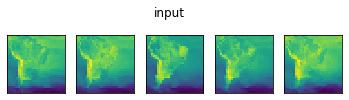

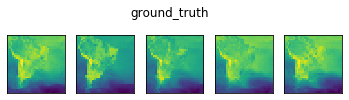

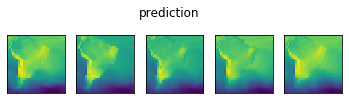

In [14]:
test_rmse, test_mae = None, None
evaluator = Evaluator(model, criterion, optimizer, test_loader, device, util, step)
best_epoch, val_loss = evaluator.load_checkpoint(checkpoint_filename)
if not(only_training):
    test_rmse, test_mae = evaluator.eval(is_chirps=is_chirps)
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

In [15]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [16]:
model_info = {'Notebook': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_rmse': test_rmse,
              'test_mae': test_mae,
              'step': step,
              'num_layers': model_param['num_layers'],
              'kernel_size': model_param['kernel_size'],
              'hidden_dim': model_param['hidden_dim'],
              'dropout_rate': dropout_rate,
              'learning_rate': lr,
              'dataset': dataset,
              'hostname': platform.node()}

In [17]:
#util.send_email(model_info)